In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def wide_labels(x):
    if "ASIAN" in x:
        return "ASIAN"
    elif "AFRICAN" in x:
        return "BLACK"
    elif "HISPANIC" in x:
        return "HISPANIC"
    elif "WHITE" in x:
        return "WHITE"
    elif "NATIVE" in x:
        return "NATIVE"
    else:
        return "OTHER"

def narrow_labels(x):
    if "ASIAN" in x or "AFRICAN" in x or "HISPANIC" in x or "NATIVE" in x: 
        return "NON-WHITE"
    elif "WHITE" in x:
        return "WHITE"
    else:
        return "OTHER"

def get_ethnicity_dataset(df, label_translation, path_out=None):

    df["ETHNICITY_LABEL"] = df["ETHNICITY"].apply(lambda x:label_translation(x))
    df_ethnicity = df[["ETHNICITY_LABEL","TEXT"]]
    
    if path_out:
        df_ethnicity.to_csv(path_out,index=False, sep="\t", header=False)
        
    return df_ethnicity

def extract_patients(mimic_path, sample_size=None):
    all_notes = pd.read_csv(mimic_path+"NOTEEVENTS.CSV.gz")
    all_patients = pd.read_csv(mimic_path+"PATIENTS.CSV.gz")
    all_admissions = pd.read_csv(mimic_path+"ADMISSIONS.CSV.gz")
    #filter relevant columns
    notes = all_notes[["TEXT"]]
    notes["TEXT"] = notes["TEXT"].apply(lambda x: x.replace("\n","").replace("\t","").lower())
    patients = all_patients[["SUBJECT_ID","GENDER"]]
    admissions = all_admissions[["INSURANCE","LANGUAGE","RELIGION","ETHNICITY","HOSPITAL_EXPIRE_FLAG"]]
    #subsample?
    if sample_size:        
        patients = patients[:sample_size]
    #join dataframes
    patients = patients.join(admissions, how="inner", on="SUBJECT_ID",rsuffix="A_")
    patients = patients.join(notes, how="inner", on="SUBJECT_ID",rsuffix="N_")
    return patients
    

## Read Data

In [34]:
raw_data_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
out_data_path = "/Users/samir/Dev/projects/TADAT/experiments/MIMIC/DATA/input/"
PATIENT_SAMPLE_SIZE = 3000
mini_patients = extract_patients(raw_data_path, PATIENT_SAMPLE_SIZE)
mini_patients

/Users/samir/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/samir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SUBJECT_ID,GENDER,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,HOSPITAL_EXPIRE_FLAG,TEXT
0,249,F,Medicaid,NaN,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,0,admission date: [**2149-6-2**] discharg...
1,250,F,Medicare,NaN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,0,admission date: [**2149-9-2**] discharg...
2,251,M,Medicaid,NaN,PROTESTANT QUAKER,BLACK/AFRICAN AMERICAN,0,admission date: [**2193-1-8**] d...
3,252,M,Medicare,NaN,CATHOLIC,OTHER,0,admission date: [**2133-9-3**] d...
4,253,F,Private,NaN,NOT SPECIFIED,HISPANIC OR LATINO,0,admission date: [**2103-8-16**] discharge...
5,255,M,Medicaid,NaN,PROTESTANT QUAKER,UNKNOWN/NOT SPECIFIED,0,admission date: [**2196-4-27**] discharge...
6,256,M,Private,ENGL,NOT SPECIFIED,BLACK/AFRICAN AMERICAN,0,admission date: [**2113-5-10**] discharge...
7,257,F,Medicare,NaN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,1,admission date: [**2158-1-5**] d...
8,258,F,Medicare,NaN,CATHOLIC,UNKNOWN/NOT SPECIFIED,0,admission date: [**2137-4-23**] discharge...
9,260,F,Medicare,NaN,OTHER,WHITE,0,admission date: [**2191-4-8**] discharge ...


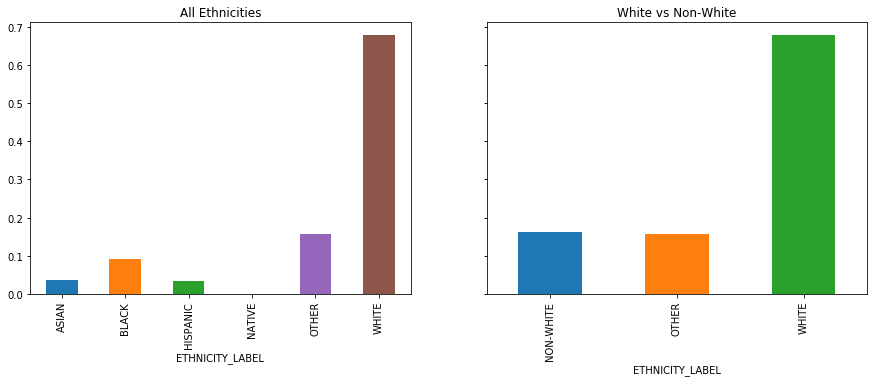

In [7]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
df_ethnicity_all = get_ethnicity_dataset(mini_patients, wide_labels)
dfg = df_ethnicity_all.groupby("ETHNICITY_LABEL").size()/df_ethnicity_all.groupby("ETHNICITY_LABEL").size().sum()
dfg.plot(ax=ax[0],kind="bar", title="All Ethnicities")

df_ethnicity = get_ethnicity_dataset(mini_patients, narrow_labels)
df2g = df_ethnicity.groupby("ETHNICITY_LABEL").size()/df_ethnicity.groupby("ETHNICITY_LABEL").size().sum()
df2g.plot(ax=ax[1], kind="bar", title="White vs Non-White")


## Analytics

In [8]:
def get_training_data(df, split):
    #split into training and test sets
    train_split, test_split = data.shuffle_split(ethnicity_dataset, split)
    #vectorize instances
    train_X = data.getX(train_split)
    test_X = data.getX(test_split)
    train_X, word_vocab = vectorizer.docs2idx(train_X)
    test_X,_ = vectorizer.docs2idx(test_X, word_vocab)
    #vectorize labels
    train_Y = data.getY(train_split)
    test_Y = data.getY(test_split)
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y,_ = vectorizer.label2idx(test_Y, label_vocab)
    return train_X, train_Y, test_X, test_Y, word_vocab, label_vocab

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-bin":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-freq":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-bin":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-sum": 
        X = features.BOE(data, word_vectors,"sum")
    else:
        raise NotImplementedError
    return X
    

def run_classifier(X_train, Y_train, X_test, Y_test,
                   labels, model_name, random_seed=1234, res_path=None):
    model = SGDClassifier(random_state=random_seed)
    model.fit(X_train,Y_train)
    Y_hat = model.predict(X_test)
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    acc = accuracy_score(Y_test, Y_hat)
    precision, recall, fscore, support = score(Y_test, Y_hat)

    res = {"model":model_name, \
            "seed":random_seed, \
            "acc":round(acc,3), \
            "microF1":round(microF1,3)
            }

    for l, i in labels.items():
        res["{}-f1".format(l[0])] = round(fscore[i],3)
    helpers.print_results(res)
    if res_path is not None:
        cols = ["dataset", "model", "acc", "avgF1"]
        # helpers.save_results(res, res_path, sep="\t", columns=cols)
        helpers.save_results(res, res_path, sep="\t")
    return res




In [15]:
#transform the data into the right format
ethnicity_dataset = data.read_dataframe(df_ethnicity,'TEXT','ETHNICITY_LABEL')
split=0.8
#get vectorized train/test data 
train_X, train_Y, test_X, test_Y, word_vocab, label_vocab = get_training_data(ethnicity_dataset, split)
#extract features
train_BOW = get_features(train_X, len(word_vocab), "BOW-bin")
test_BOW = get_features(test_X, len(word_vocab), "BOW-bin")
train_BOW_freq = get_features(train_X, len(word_vocab), "BOW-freq")
test_BOW_freq = get_features(test_X, len(word_vocab), "BOW-freq")


(sparse BOW)
(sparse BOW)
(sparse BOW)
(sparse BOW)


In [24]:
embeddings_path = "/Users/samir/Dev/resources/embeddings/word_embeddings.txt"
E, _ = embeddings.read_embeddings(embeddings_path, word_vocab, "latin-1")
train_BOE_bin = get_features(train_X, len(word_vocab), "BOE-bin", E)
test_BOE_bin = get_features(test_X, len(word_vocab), "BOE-bin", E)

train_BOE_sum = get_features(train_X, len(word_vocab), "BOE-sum", E)
test_BOE_sum = get_features(test_X, len(word_vocab), "BOE-sum", E)


88402/96337 (91.76 %) words in vocabulary found no embedding


In [26]:
random_seeds = [1,2,3,4,5]
# random_seeds = [1]
results_BOW = []
results_BOW_freq = []
results_BOE_bin = []
results_BOE_sum = []
for r in random_seeds:
    print("[running seed: {}]".format(r))
    res_bow = run_classifier(train_BOW, train_Y, test_BOW, test_Y, label_vocab, "BOW-bin", r)
    res_freq = run_classifier(train_BOW_freq, train_Y, test_BOW_freq, test_Y, label_vocab, "BOW-freq", r)
    res_boe_bin = run_classifier(train_BOE_bin, train_Y, test_BOE_bin, test_Y, label_vocab, "BOE-bin", r)
    res_boe_sum = run_classifier(train_BOE_sum, train_Y, test_BOE_sum, test_Y, label_vocab, "BOE-sum", r)
    results_BOW.append(res_bow)
    results_BOW_freq.append(res_freq)
    results_BOE_bin.append(res_boe_bin)
    results_BOE_sum.append(res_boe_sum)

[running seed: 1]
** model: BOW-bin| seed: 1| acc: 0.609| microF1: 0.609| W-f1: 0.761| N-f1: 0.105| O-f1: 0.162| 
** model: BOW-freq| seed: 1| acc: 0.651| microF1: 0.651| W-f1: 0.793| N-f1: 0.018| O-f1: 0.018| 
** model: BOE-bin| seed: 1| acc: 0.677| microF1: 0.677| W-f1: 0.808| N-f1: 0.0| O-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


** model: BOE-sum| seed: 1| acc: 0.677| microF1: 0.677| W-f1: 0.808| N-f1: 0.0| O-f1: 0.0| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.662| microF1: 0.662| W-f1: 0.794| N-f1: 0.082| O-f1: 0.097| 
** model: BOW-freq| seed: 2| acc: 0.656| microF1: 0.656| W-f1: 0.793| N-f1: 0.0| O-f1: 0.111| 
** model: BOE-bin| seed: 2| acc: 0.679| microF1: 0.679| W-f1: 0.808| N-f1: 0.0| O-f1: 0.021| 
** model: BOE-sum| seed: 2| acc: 0.677| microF1: 0.677| W-f1: 0.807| N-f1: 0.0| O-f1: 0.021| 
[running seed: 3]
** model: BOW-bin| seed: 3| acc: 0.657| microF1: 0.657| W-f1: 0.795| N-f1: 0.017| O-f1: 0.04| 
** model: BOW-freq| seed: 3| acc: 0.163| microF1: 0.163| W-f1: 0.033| N-f1: 0.08| O-f1: 0.262| 
** model: BOE-bin| seed: 3| acc: 0.158| microF1: 0.158| W-f1: 0.0| N-f1: 0.0| O-f1: 0.273| 
** model: BOE-sum| seed: 3| acc: 0.158| microF1: 0.158| W-f1: 0.0| N-f1: 0.0| O-f1: 0.273| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.612| microF1: 0.612| W-f1: 0.764| N-f1: 0.158| O-f1: 0.134| 
** m

## Results

Text(0.5,1,'boe-sum')

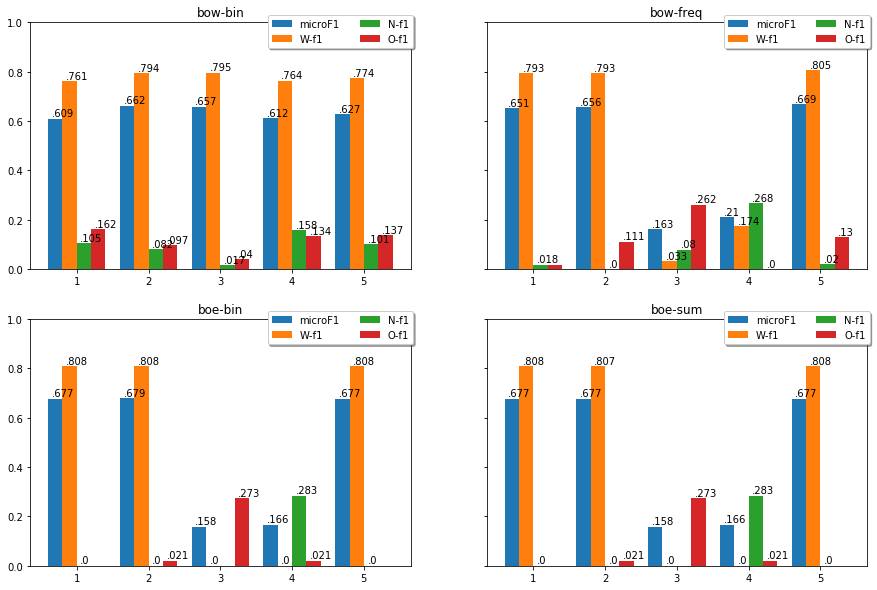

In [32]:
df_bb = pd.DataFrame(results_BOW)
df_bf = pd.DataFrame(results_BOW_freq)
df_boeb = pd.DataFrame(results_BOE_bin)
df_boes = pd.DataFrame(results_BOE_sum)

fig, ax = plt.subplots(2,2, sharey=True, figsize=(15,10))

plots.plot_df(df=df_bb,ax=ax[0][0],x="seed",ys=["microF1","W-f1","N-f1","O-f1"], annotation_size=10)
plots.plot_df(df=df_bf,ax=ax[0][1],x="seed",ys=["microF1","W-f1","N-f1","O-f1"], annotation_size=10)
plots.plot_df(df=df_boeb,ax=ax[1][0],x="seed",ys=["microF1","W-f1","N-f1","O-f1"], annotation_size=10)
plots.plot_df(df=df_boes,ax=ax[1][1],x="seed",ys=["microF1","W-f1","N-f1","O-f1"], annotation_size=10)


ax[0][0].set_title("bow-bin")
ax[0][1].set_title("bow-freq")
ax[1][0].set_title("boe-bin")
ax[1][1].set_title("boe-sum")

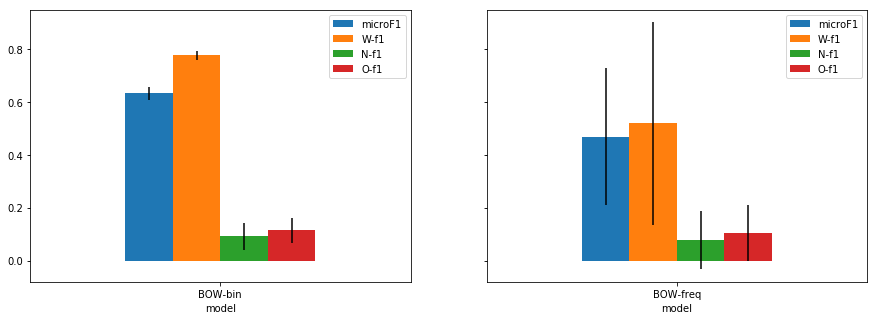

In [11]:
df_bb_mean = df_bb.groupby("model").mean()
df_bb_std = df_bb.groupby("model").std()

df_bf_mean = df_bf.groupby("model").mean()
df_bf_std = df_bf.groupby("model").std()

fig2, ax2 = plt.subplots(1,2, sharey=True, figsize=(15,5))

df_bb_mean[["microF1","W-f1","N-f1","O-f1"]].plot(ax=ax2[0],legend=True,kind="bar",yerr=df_bb_std, rot=0)
df_bf_mean[["microF1","W-f1","N-f1","O-f1"]].plot(ax=ax2[1],legend=True,kind="bar",yerr=df_bf_std, rot=0)

Text(0.5,1,'bow-freq')

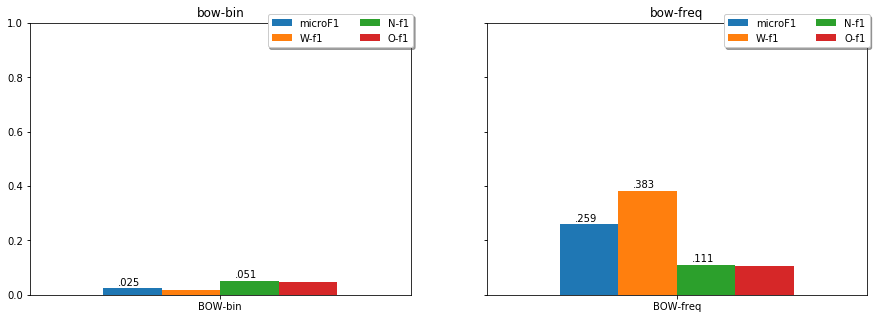

In [12]:
fig2, ax2 = plt.subplots(1,2, sharey=True, figsize=(15,5))

plots.plot_df(df=df_bb_std.reset_index(),ax=ax2[0],x="model",ys=["microF1","W-f1","N-f1","O-f1"], annotation_size=10)
plots.plot_df(df=df_bf_std.reset_index(),ax=ax2[1],x="model",ys=["microF1","W-f1","N-f1","O-f1"], annotation_size=10)

ax2[0].set_title("bow-bin")
ax2[1].set_title("bow-freq")